# Objectives of this document

This will give a walkthrough of the output of the code, along with some explanations of what is happening

To start, run the initial string method calculation with

```bash
mpirun -np 16 omm-fts
```

This will generate a folder 'runs', of which there will be a file 'ala2_0_string.h5', with a copy included here for ease.
Looking at the string along with a reference free energy surface of alanine dipeptide obtained through OPES-explore, we see the following

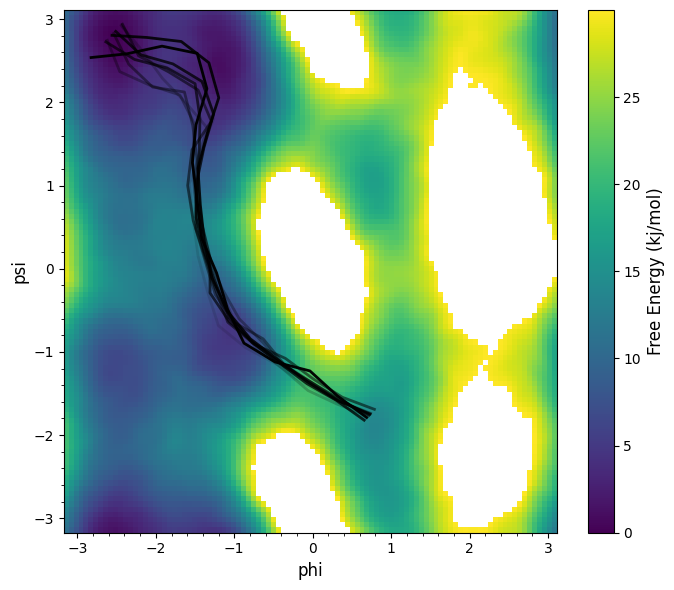

In [ ]:
import h5py
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import CloughTocher2DInterpolator

cmap = plt.cm.viridis

# Load in string
string_file = h5py.File("ala2_0_string.h5", "r")
len_h5 = len(string_file.keys())
strings = []
for i in range(len(string_file)):
    strings.append(string_file[f"config_{i}/cvs"][:])
# Load in FES data
fes_data = np.loadtxt("fes-rew.dat")

# Plot
X, Y, fes = fes_data[:, 0], fes_data[:, 1], fes_data[:, 2]
fes = fes.reshape((100, 100))
X = X.reshape((100, 100))
Y = Y.reshape((100, 100))

fig = plt.figure(figsize=(7.0, 6.0))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

fes_filter = np.where(fes > 30, np.nan, fes)
pcm = ax.pcolormesh(X, Y, fes_filter, shading="auto", cmap=cmap)
for i in range(0, len_h5, 20):
    ax.plot(strings[i][:, 0], strings[i][:, 1], "k-", alpha=i / len_h5, linewidth=2)

# Add a colorbar
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label(r"Free Energy (kj/mol)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Set labels and ticks
ax.set_xlabel(r"phi", fontsize=12)
ax.set_ylabel(r"psi", fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=10)

plt.tight_layout()
plt.show()

The code should able to succesfully capture the the dominant pathway from the initial starting basin and the final basin.
Now, we will run a script that will interpolate the string to be used as an input to the Hamiltonian replica exchange simulation.
This will be done with the command

```bash
omm-interpolate-string
```

Which will generate a file 'ala2_interpolated_string.h5' in the same folder.
This is done to increase acceptance rates in the Hamiltonian replica exchange simulation.

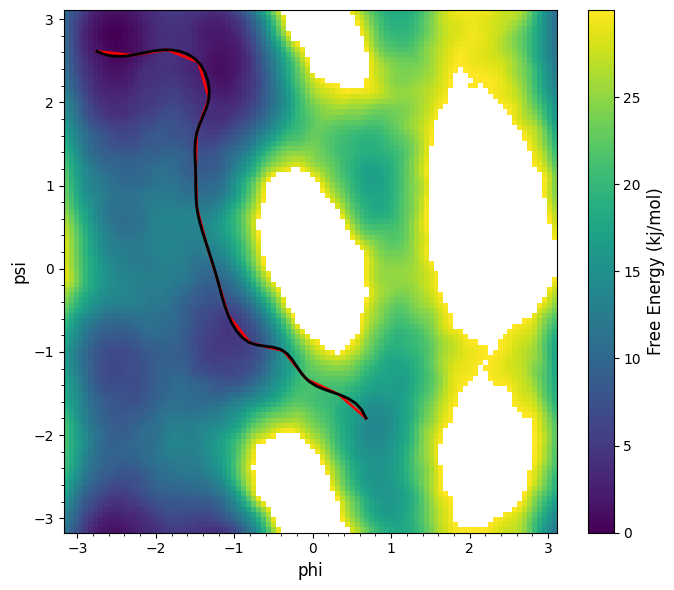

In [9]:
string_interpolated_file = h5py.File("ala2_interpolated_string.h5", "r")
# Load in string
cv_values_interpolated = string_interpolated_file["cvs"][:]

fig = plt.figure(figsize=(7.0, 6.0))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

fes_filter = np.where(fes > 30, np.nan, fes)
pcm = ax.pcolormesh(X, Y, fes_filter, shading="auto", cmap=cmap)
ax.plot(strings[-1][:, 0], strings[-1][:, 1], "r-", alpha=i / len_h5, linewidth=2)
ax.plot(cv_values_interpolated[:, 0], cv_values_interpolated[:, 1], "k-", linewidth=2)

# Add a colorbar
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label(r"Free Energy (kj/mol)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Set labels and ticks
ax.set_xlabel(r"phi", fontsize=12)
ax.set_ylabel(r"psi", fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=10)

plt.tight_layout()
plt.show()

The Hamiltonian replica exchange simulation can then be run with the command

```bash
mpirun -np 64 omm-replica
```

On a standard desktop, use of '--oversubscribe' might be necessary due to the number of cores needed by MPI, though given this is alanine dipeptide it will likely not overwhelm the system.
This will yield a new folder, along with files "replica_ranks.h5" and "swap_rates.h5" that we will now look at.

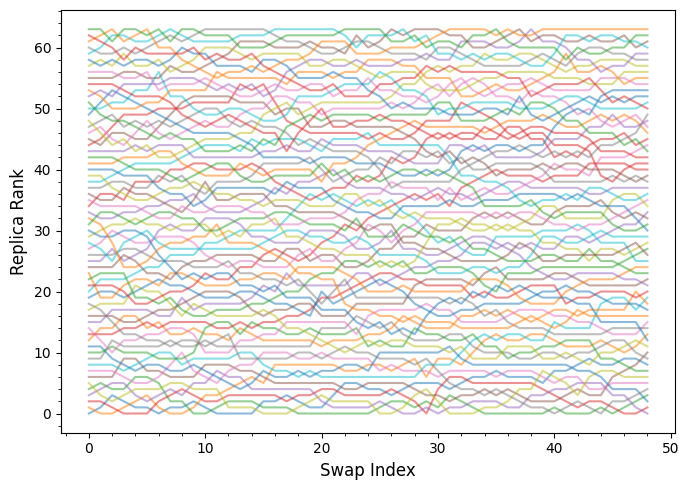

In [10]:
replica_ranks_file = h5py.File("replica_ranks.h5", "r")
len_h5 = len(replica_ranks_file.keys())
replica_ranks = []
for i in range(len_h5):
    replica_ranks.append(replica_ranks_file[f"config_0_{i}"][:])
replica_ranks_file.close()
replica_ranks = np.array(replica_ranks)
# plot replica ranks
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(64):
    ax.plot(replica_ranks[:, i], label=f"Replica {i + 1}", alpha=0.5)
ax.set_xlabel("Swap Index", fontsize=12)
ax.set_ylabel("Replica Rank", fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=10)

plt.tight_layout()
plt.show()

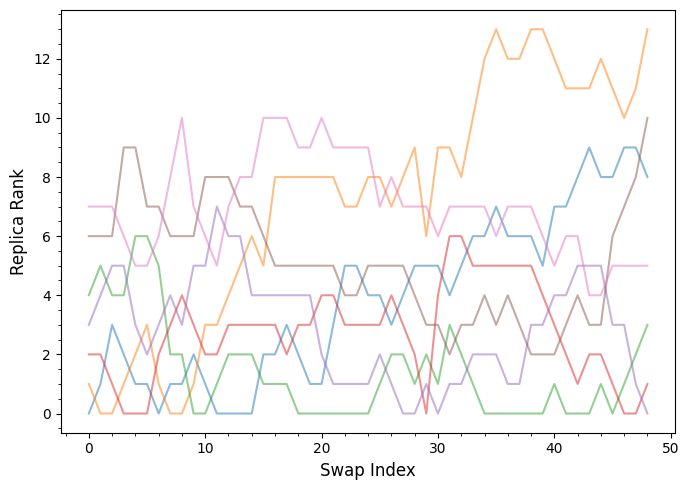

In [11]:
# plot first 7 replicas for clarity
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(7):
    ax.plot(replica_ranks[:, i], label=f"Replica {i + 1}", alpha=0.5)
ax.set_xlabel("Swap Index", fontsize=12)
ax.set_ylabel("Replica Rank", fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=10)

plt.tight_layout()
plt.show()

The replicas are able to diffuse through the string, indicative of good mixing and acceptance rates between the replicas.
Looking at the swap rates to get a better idea of the acceptance rates....

/tmp/ipykernel_1474906/2933685352.py:6: RuntimeWarning: invalid value encountered in divide
  ratio = num_accepted / num_attempted


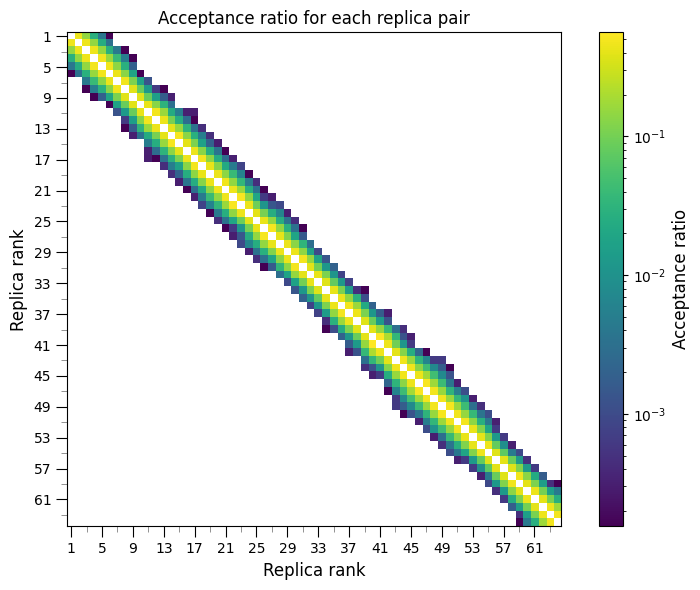

In [ ]:
swap_rates_file = h5py.File("swap_rates.h5", "r")
len_swap_rates = len(swap_rates_file.keys())
final_config = swap_rates_file[f"config_0_{len_swap_rates - 1}"]
num_accepted = final_config["num_accepted"][()]
num_attempted = final_config["num_attempted"][()]
ratio = num_accepted / num_attempted
ratio[np.isnan(ratio)] = 0.0
# plot the acceptance ratio as a heatmap

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    ratio, cmap=cmap, norm=LogNorm(vmin=np.min(ratio[ratio > 0]), vmax=np.max(ratio))
)
tick_spacing = 4
ticks = np.arange(0, 64, tick_spacing)
minor_tick_spacing = 2
minor_ticks = np.arange(0, 64, minor_tick_spacing)
labels = ticks + 1
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(minor_ticks, minor=True)
ax.tick_params(axis="both", which="minor", length=4, color="gray")
ax.tick_params(axis="both", which="major", length=8)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r"Acceptance ratio", fontsize=12)
ax.set_xlabel(r"Replica rank", fontsize=12)
ax.set_ylabel(r"Replica rank", fontsize=12)
ax.set_title(r"Acceptance ratio for each replica pair", fontsize=12)
plt.tight_layout()
plt.show()

The acceptance ratios are above 0.2, which is a good value for Hamiltonian replica exchange simulations.
We will now analyze the free energy of the string, and compare it to the reference free energy surface.
To do so, we will run the following script

```bash
omm-analyze-fe
```

this will generate a file 'ala2_free_energy.h5' in the same folder, that we will now compare against the reference free energy surface.

In [ ]:
# load in free energy
fes_file = h5py.File("ala2_free_energy.h5", "r")
cvs_fes = fes_file["cvs"][:]
t_fes = fes_file["t_spline"][:]
fe_mean = fes_file["fe_mean"][:]
fe_std = fes_file["fe_std"][:]

# compute the free energy of the string on the reference free energy surface

X_flatten = X.flatten()
Y_flatten = Y.flatten()
fes_flatten = fes.flatten()
X_curve = np.array([X_flatten, Y_flatten]).T
fes_interp = CloughTocher2DInterpolator(X_curve, fes_flatten)
fes_ref = fes_interp(cvs_fes)

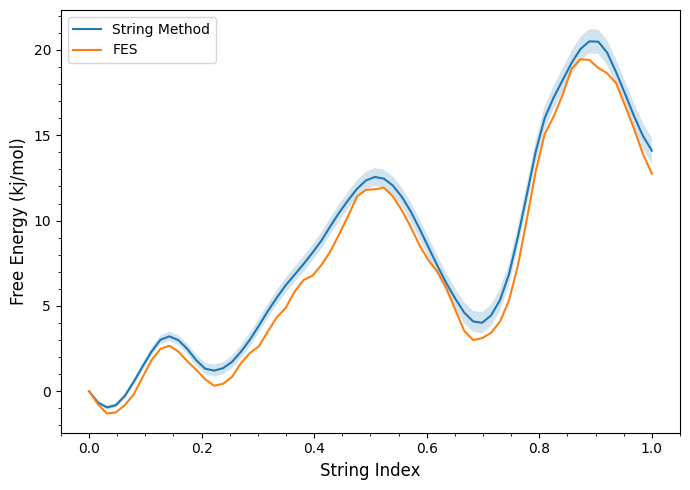

In [14]:
# plot curves together
fig = plt.figure(figsize=(7.0, 5.0))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

ax.plot(t_fes, fe_mean, label=r"String Method")
ax.fill_between(t_fes, fe_mean - fe_std, fe_mean + fe_std, alpha=0.2)
ax.plot(t_fes, fes_ref - fes_ref[0], label=r"FES")

# Set labels and ticks
ax.set_xlabel(r"String Index", fontsize=12)
ax.set_ylabel(r"Free Energy (kj/mol)", fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=10)
ax.legend()

plt.tight_layout()
plt.show()

This is relatively good agreement given the short default simulation time of 0.2 ns, and can be improved with longer simulations.